<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Modelos polarimetría Mueller </font>
</div>

- **Para**: Paper calibración SLM Mueller

- **Fecha**: 2023/01/26
        
- **Autores**: Jesús del Hoyo

- **Objetivos**: Tener un resumen claro de los modelos de polarimetría Mueller de la literatura y nuestro.

- **Descripción** 

- **Referencias**: Al final del todo.


# Comparacion varios condition numbers

Voy a comparar los métodos Stokes-Mueller con diferentes definiciones de condition numbers (es decir, diferentes normas).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import optimize
import sympy as sy
from copy import deepcopy
from pyswarms.single.global_best import GlobalBestPSO
from itertools import combinations

from py_pol.mueller import Mueller, Stokes, degrees
from py_lab.config import angle_P1, angle_Q1, angle_Q2, angle_P2
from py_lab.utils import PSA_states_2_angles, PSG_states_2_angles, PSA_angles_2_states, PSG_angles_2_states
import matplotlib.pyplot as plt

In [3]:
def W_from_S(S_PSG, S_PSA):
    """Funcion para calcular la matriz W a partir de los estados del PSG y del PSA.

    Args:
        S_PSG (Stokes): States of the PSG.
        S_PSA (Stokes): States of the PSA.

    Returns:
        W (np.ndarray): W matrix.
    """
    # Prealocate matrix
    N = S_PSA.size * S_PSG.size
    W = np.zeros((N,16))

    # Calculate matrix
    ind = 0
    for ind_G in range(S_PSG.size):
        for ind_A in range(S_PSA.size):
            # Calculate row
            MA = S_PSA.M[:,ind_A, np.newaxis]
            MG = S_PSG.M[np.newaxis,:,ind_G]
            M = MA @ MG

            # Assign row
            W[ind,:] = 0.5 * M.flatten()
            ind += 1

    return W

In [4]:
def W_inv(W):
    """Calculate the inverse or pseudoinverse matrix of W.

    Args:
        W (np.ndarray): W matrix to invert.

    Returns:
        Wi (np.ndarray): Inverse matrix.
    """
    # Caso N = 16
    if W.shape[0] == W.shape[1]:
        if np.linalg.matrix_rank(W) == W.shape[0]:
            Wi = np.linalg.inv(W)
        else:
            print("WARNING: Non-invertible matrix")
            return W
    # Casos N > 16
    else:
        Wi = np.linalg.inv(W.T @ W) @ W.T

    return Wi

In [40]:
def norma_Frobenius(W):
    """Suma cuadratica de los elementos"""
    return np.linalg.norm(W)

def norma_Vect2(W):
    """Norma vectorial de orden 2
    """
    _, singular, _ = np.linalg.svd(W)
    return singular.max()/singular.min()

def norma_invdet(W):
    """Valor absoluto de la inversa del determinante"""
    _, singular, _ = np.linalg.svd(W)
    return np.prod(1/singular)

def norma_pesos(W):
    """Norma que trata de igualar el peso de todas las medidas"""
    _, singular, _ = np.linalg.svd(W)
    return np.sum(1/singular**2)

def condition_number(W, f_norma, usar_ambas=True, usar_W=False):
    """Calcula el condition number de una matriz NxM.

    Args:
        W (np.ndarray): Matriz W

    Returns:
        kappa (float): Condition number
    """
    Wi = W_inv(W)
    if usar_ambas:
        return f_norma(W) * f_norma(Wi) # / (W.shape[0]/16)**(1)
    elif usar_W:
        return f_norma(W)
    else:
        return f_norma(Wi)

## Poliedros regulares

Voy a calcular todos los condition numbers de los poliedros regulares

In [6]:
# Estados
phi = (1+np.sqrt(5))/2
r3 = np.sqrt(3)
raiz = np.sqrt(1 + phi**2)

Tetraedro = np.array([[1, 1, 0, 0], [1, -1/3, np.sqrt(8)/3, 0], [1, -1/3, -np.sqrt(2)/3, np.sqrt(6)/3], [1, -1/3, -np.sqrt(2)/3, -np.sqrt(6)/3]]).T
Octaedro = np.array([[1, 1, 0, 0], [1, -1, 0, 0], [1, 0, 1, 0], [1, 0, -1, 0], [1, 0, 0, 1], [1, 0, 0, -1] ]).T
Cubo = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1]]) / r3
Icosaedro = np.array([[raiz, 0, 1, phi], [raiz, 0, -1, phi], [raiz, 0, 1, -phi], [raiz, 0, -1, -phi], 
    [raiz, 1, phi, 0], [raiz, -1, phi, 0], [raiz, 1, -phi, 0], [raiz, -1, -phi, 0],
    [raiz, phi, 0, 1], [raiz, -phi, 0, 1], [raiz, phi, 0, -1], [raiz, -phi, 0, -1],
]) / raiz
Dodecaedro = np.array([[r3, 1, 1, 1], [r3, 1, 1, -1], [r3, 1, -1, 1], [r3, -1, 1, 1], [r3, -1, -1, 1], [r3, -1, 1, -1], [r3, 1, -1, -1], [r3, -1, -1, -1], 
    [r3, 0, phi, 1/phi], [r3, 0, -phi, 1/phi], [r3, 0, phi, -1/phi], [r3, 0, -phi, -1/phi], 
    [r3, 1/phi, 0, phi], [r3, -1/phi, 0, phi], [r3, 1/phi, 0, -phi], [r3, -1/phi, 0, -phi], 
    [r3, phi, 1/phi, 0], [r3, -phi, 1/phi, 0], [r3, phi, -1/phi, 0], [r3, -phi, -1/phi, 0], ]) / r3

S_4 = Stokes().from_matrix(Tetraedro)
S_6 = Stokes().from_matrix(Octaedro)
S_8 = Stokes().from_matrix(Cubo)
S_12 = Stokes().from_matrix(Icosaedro)
S_20 = Stokes().from_matrix(Dodecaedro)
lista = [S_4, S_6, S_8, S_12, S_20]

In [48]:
# Combinaciones
N = len(lista)
kappa_perfect = np.zeros((8,15))
Nmeasures_perfect = np.zeros((15))

ind = 0
for ind_G in range (N):
    S_PSG = lista[ind_G]
    for ind_A in range(0, ind_G+1):
        S_PSA = lista[ind_A]
        Nmeasures_perfect[ind] = S_PSG.size * S_PSA.size

        W = W_from_S(S_PSG, S_PSA)
        Wi = W_inv(W)
        
        kappa_perfect[0, ind] = condition_number(W, norma_Frobenius, usar_ambas=True)
        kappa_perfect[1, ind] = condition_number(W, norma_Vect2, usar_ambas=True)
        kappa_perfect[2, ind] = condition_number(W, norma_invdet, usar_ambas=True)
        kappa_perfect[3, ind] = condition_number(W, norma_pesos, usar_ambas=True)
        kappa_perfect[4, ind] = condition_number(W, norma_Frobenius, usar_ambas=False)
        kappa_perfect[5, ind] = condition_number(W, norma_Vect2, usar_ambas=False)
        kappa_perfect[6, ind] = condition_number(W, norma_invdet, usar_ambas=False, usar_W=True)
        kappa_perfect[7, ind] = condition_number(W, norma_pesos, usar_ambas=False, usar_W=True)

        ind += 1
        

In [49]:
ind = np.argsort(Nmeasures_perfect)
kappa_perfect = kappa_perfect[:, ind]
Nmeasures_perfect = Nmeasures_perfect[ind]

## Espiral

Vamos a distribuir los puntos en la esfera de Poincare con una erspiral. Es esperable que funcione mejor cuantos más puntos se usen.

In [11]:
def fill_sphere_fibonacci(num_samples=100, kind_exit='list', has_draw=False):
    """Generate a quasi - uniform distribution around the poincare sphere.

    Arguments:
        num_samples(int): number of samples.
        kind_exit(str): ('list', 'numpy_array', 'Stokes', 'Jones')

    Reference:
         https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
    """
    golden_angle = np.pi * (3. - np.sqrt(5.))  # golden angle in radians

    i = np.linspace(0, num_samples, num_samples)
    y = 1 - (i / (num_samples - 1)) * 2
    y[y > 1] = 1
    y[y < -1] = -1
    radius = np.sqrt(1 - y**2)  # radius at y
    theta = golden_angle * i  # golden angle increment
    x = np.cos(theta) * radius
    z = np.sin(theta) * radius

    if kind_exit == 'list':
        return (x, y, z)
    elif kind_exit == 'numpy_array':
        return np.vstack((x, y, z)).transpose()
    elif kind_exit == 'Stokes':
        S = Stokes("S1").from_components([np.ones_like(x), x, y, z])
        return x, y, z, S
    elif kind_exit == 'Jones':
        S = Stokes("S1").from_components([np.ones_like(x), x, y, z])
        J = Jones_vector().from_Stokes(S)
        return x, y, z, J
    else:
        print("No kind_exit parameter")
        return None

In [50]:
States = np.repeat(np.arange(4, 21), 2)
kappa_spiral = np.zeros((8, States.size - 1))
Nmeasures_spiral = np.zeros(States.size - 1)

for ind, N1 in enumerate(States[:-1]):
    N2 = States[ind+1]
    _,_,_,S1 = fill_sphere_fibonacci(num_samples=N1, kind_exit='Stokes', has_draw=False)
    _,_,_,S2 = fill_sphere_fibonacci(num_samples=N2, kind_exit='Stokes', has_draw=False)
    W = W_from_S(S1, S2)
    Wi = W_inv(W)
    Nmeasures_spiral[ind] = N1 * N2

    kappa_spiral[0, ind] = condition_number(W, norma_Frobenius, usar_ambas=True)
    kappa_spiral[1, ind] = condition_number(W, norma_Vect2, usar_ambas=True)
    kappa_spiral[2, ind] = condition_number(W, norma_invdet, usar_ambas=True)
    kappa_spiral[3, ind] = condition_number(W, norma_pesos, usar_ambas=True)
    kappa_spiral[4, ind] = condition_number(W, norma_Frobenius, usar_ambas=False)
    kappa_spiral[5, ind] = condition_number(W, norma_Vect2, usar_ambas=False)
    kappa_spiral[6, ind] = condition_number(W, norma_invdet, usar_ambas=False, usar_W=True)
    kappa_spiral[7, ind] = condition_number(W, norma_pesos, usar_ambas=False, usar_W=True)

## Aleatorios

Por último, voy a calcular el resultado de usar ángulos aleatorios. Como son aleatorios, repetiré cada caso muchas veces para poder hacer un promedio.

In [12]:
system = [
    Stokes().circular_light(),
    Mueller().diattenuator_perfect(),
    Mueller().quarter_waveplate(),
    Mueller().quarter_waveplate(),
    Mueller().diattenuator_perfect(),
]

def angles_to_W(angles):
    S, P1, R1, R2, P2 = system
    angles = np.reshape(angles, (4,int(angles.size/4)))
    Mp1_rot = P1.rotate(angle=angles[0,:], keep=True)
    Mr1_rot = R1.rotate(angle=angles[1,:], keep=True)
    Mr2_rot = R2.rotate(angle=angles[2,:], keep=True)
    Mp2_rot = P2.rotate(angle=angles[3,:], keep=True)

    PSG = Mr1_rot * (Mp1_rot * S)
    PSA = Mp2_rot * Mr2_rot
    a = PSA.M[0,:,:]
    a = a.T[:, :, np.newaxis]
    g = PSG.M.T[:, np.newaxis, :]
    W = a @ g # Similar to matmul
    W = W.reshape((W.shape[0], 16))
    
    return W

In [51]:
Nmeasures = np.linspace(16, 400, 35, dtype=int)
kappa_random = np.zeros((8, Nmeasures.size), dtype=float)
error_random = np.zeros((8, Nmeasures.size), dtype=float)
Naverage = 50

for ind, N in enumerate(Nmeasures):
    # Promediar para calcular desviacion tipica
    kappa_frob = []
    kappa_vect = []
    kappa_invdet = []
    kappa_pesos = []
    kappa_frob1 = []
    kappa_vect1 = []
    kappa_invdet1 = []
    kappa_pesos1 = []
    for indM in range(Naverage):
        angles = np.random.rand(4, N) * 180*degrees
        W = angles_to_W(angles)
        Wi = W_inv(W)
        Id = Wi @ W
        error = np.sum((Id - np.eye(Id.shape[0]))**2)
        if error < 1e-10:
            kappa_frob.append(condition_number(W, norma_Frobenius, usar_ambas=True))
            kappa_vect.append(condition_number(W, norma_Vect2, usar_ambas=True))
            kappa_invdet.append(condition_number(W, norma_invdet, usar_ambas=True))
            kappa_pesos.append(condition_number(W, norma_pesos, usar_ambas=True))
            kappa_frob1.append(condition_number(W, norma_Frobenius, usar_ambas=False))
            kappa_vect1.append(condition_number(W, norma_Vect2, usar_ambas=False))
            kappa_invdet1.append(condition_number(W, norma_invdet, usar_ambas=False, usar_W=True))
            kappa_pesos1.append(condition_number(W, norma_pesos, usar_ambas=False, usar_W=True))

    # Resultado
    kappa_random[0, ind] = np.average(kappa_frob)
    kappa_random[1, ind] = np.average(kappa_vect)
    kappa_random[2, ind] = np.average(kappa_invdet)
    kappa_random[3, ind] = np.average(kappa_pesos)
    kappa_random[4, ind] = np.average(kappa_frob1)
    kappa_random[5, ind] = np.average(kappa_vect1)
    kappa_random[6, ind] = np.average(kappa_invdet1)
    kappa_random[7, ind] = np.average(kappa_pesos1)

    error_random[0, ind] = np.std(kappa_frob)
    error_random[1, ind] = np.std(kappa_vect)
    error_random[2, ind] = np.std(kappa_invdet)
    error_random[3, ind] = np.std(kappa_pesos)
    error_random[4, ind] = np.std(kappa_frob1)
    error_random[5, ind] = np.std(kappa_vect1)
    error_random[6, ind] = np.std(kappa_invdet1)
    error_random[7, ind] = np.std(kappa_pesos1)

## Comparación de métodos

Voy a comparar el resultado de los diferentes métodos visualmente con figuras.

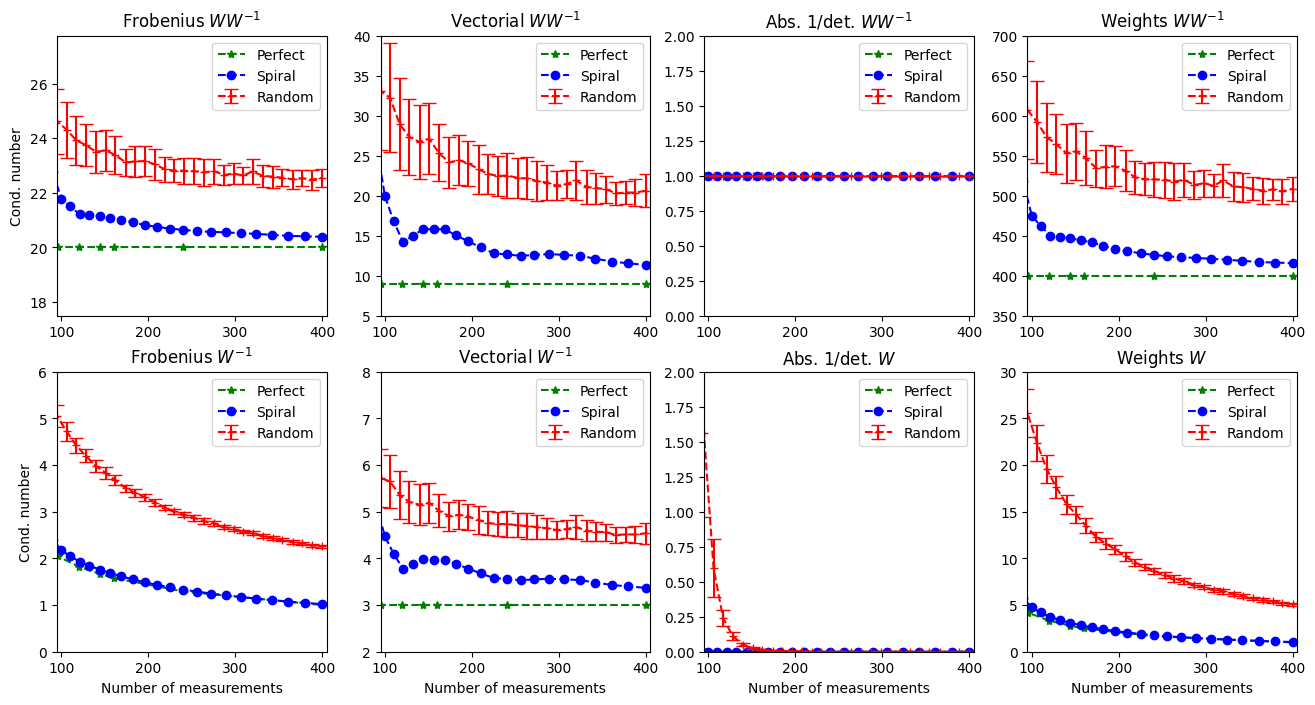

In [55]:
plt.figure(figsize=(16,8))
titles = ("Frobenius $W W^{-1}$", "Vectorial $W W^{-1}$", "Abs. 1/det. $W W^{-1}$", "Weights $W W^{-1}$", 
    "Frobenius $W^{-1}$", "Vectorial $W^{-1}$", "Abs. 1/det. $W$", "Weights $W$",)
ylims = ([17.5, 27.75], [5, 40], [0, 2], [350, 700], [0, 6], [2, 8], [0, 2], [0, 30])
for ind in range(8):
    plt.subplot(2,4,ind+1)
    plt.plot(Nmeasures_perfect, kappa_perfect[ind, :], "g*--", label="Perfect")
    plt.plot(Nmeasures_spiral, kappa_spiral[ind, :], "bo--", label="Spiral")
    plt.errorbar(Nmeasures, kappa_random[ind, :], yerr=error_random[ind, :], fmt="r+--", label="Random", capsize=5)
    plt.title(titles[ind])
    plt.legend()
    plt.ylim(ylims[ind])
    plt.xlim([95, 405])
    if ind > 3:
        plt.xlabel("Number of measurements")
    if ind in (0,4):
        plt.ylabel("Cond. number")

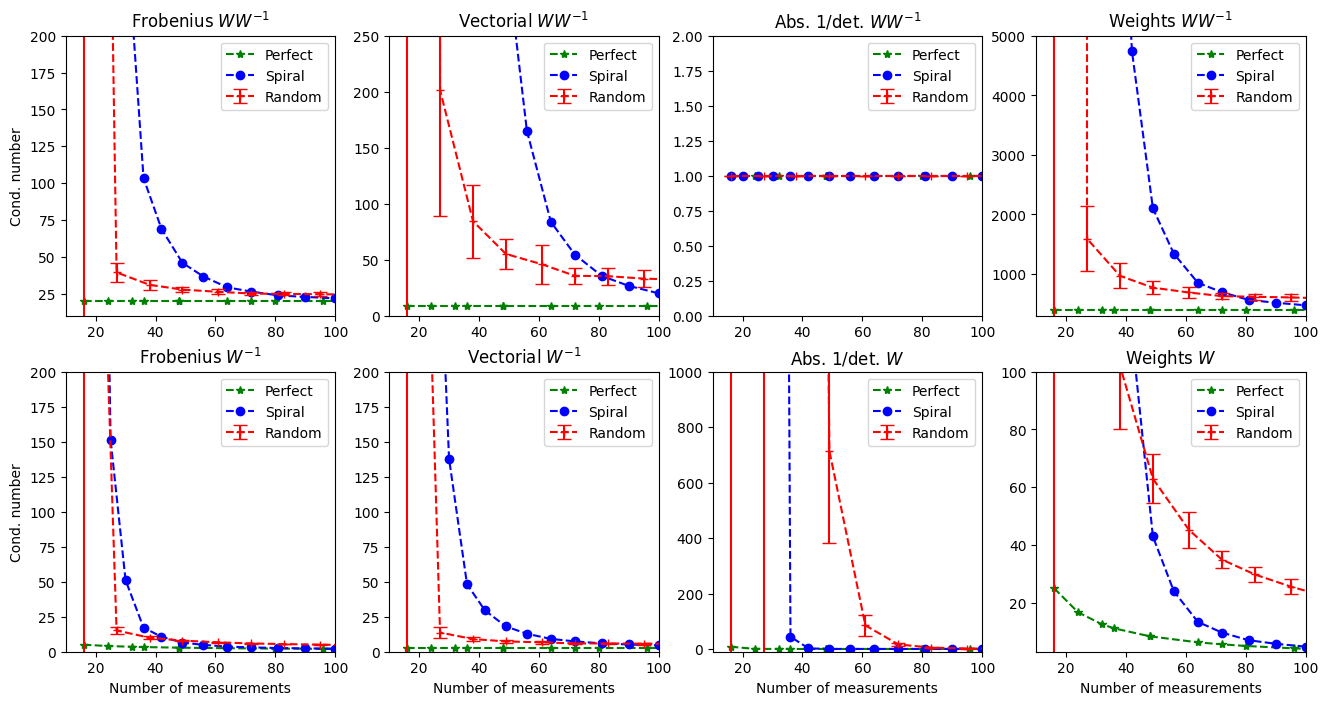

In [60]:
plt.figure(figsize=(16,8))
titles = ("Frobenius $W W^{-1}$", "Vectorial $W W^{-1}$", "Abs. 1/det. $W W^{-1}$", "Weights $W W^{-1}$", 
    "Frobenius $W^{-1}$", "Vectorial $W^{-1}$", "Abs. 1/det. $W$", "Weights $W$",)
ylims = ([10, 200.], [0, 250], [0, 2], [300, 5000], [0, 200], [0, 200], [-10, 1000], [3, 100])
for ind in range(8):
    plt.subplot(2,4,ind+1)
    plt.plot(Nmeasures_perfect, kappa_perfect[ind, :], "g*--", label="Perfect")
    plt.plot(Nmeasures_spiral, kappa_spiral[ind, :], "bo--", label="Spiral")
    plt.errorbar(Nmeasures, kappa_random[ind, :], yerr=error_random[ind, :], fmt="r+--", label="Random", capsize=5)
    plt.title(titles[ind])
    plt.legend()
    plt.ylim(ylims[ind])
    plt.xlim([10, 100])
    if ind > 3:
        plt.xlabel("Number of measurements")
    if ind in (0,4):
        plt.ylabel("Cond. number")

Independientemente de la metrica escogida, el mejor método son los sólidos regulares. Además, en todos los casos el método espiral mejora el método random. EL corte depende de la norma utilizada, pero oscila entre 50 y 90 medidas.